In [7]:
"""
@author: Crazy Trader
Trading Hours (HKT Timezone) Mon - Fri: 
    HSI Derivatives(Day Session)    : 09:15 - 12:00, 13:00 - 16:30
                   (Night Session)  : 17:15 - 01:00
    HK Equities    (Auction Session): 09:00 - 09:30
                   (Day Session)    : 09:30 - 12:00, 13:00 - 16:08
    US Equities                     : 22:30 - 05:00
    Forex                           : 00:00 - 23:59
Restrictions:
    Trading must be in trading hours
    Trading must be in sufficnet cash
    Option Strike Price is in step of 200
    Backtest would be stopped with restriction
Assumptions:
    Open/Close Rate means Bid/Ask for FX, Close for EQ, and Strike for Options
    Option price based on Interest rate is 0.15% and dividend yield is 4.24%, per year
    no overnight fee incurred
Operations:
    Long with Ask Price
    Short with Bid Price
"""

'\n@author: Crazy Trader\nTrading Hours (HKT Timezone) Mon - Fri: \n    HSI Derivatives(Day Session)    : 09:15 - 12:00, 13:00 - 16:30\n                   (Night Session)  : 17:15 - 01:00\n    HK Equities    (Auction Session): 09:00 - 09:30\n                   (Day Session)    : 09:30 - 12:00, 13:00 - 16:08\n    US Equities                     : 22:30 - 05:00\n    Forex                           : 00:00 - 23:59\nRestrictions:\n    Trading must be in trading hours\n    Trading must be in sufficnet cash\n    Option Strike Price is in step of 200\n    Backtest would be stopped with restriction\nAssumptions:\n    Open/Close Rate means Bid/Ask for FX, Close for EQ, and Strike for Options\n    Option price based on Interest rate is 0.15% and dividend yield is 4.24%, per year\n    no overnight fee incurred\nOperations:\n    Long with Ask Price\n    Short with Bid Price\n'

In [8]:
#%% Library & Initialize Dataset and Backtesting Platform
from library.functions import *
dataset = {}
dataset['0005.HK']  = 'EQ'       # Close, Volume
dataset['0700.HK']  = 'EQ'       # Close, Volume
dataset['HSI']      = 'EQ'       # Close, Volume
dataset['PUT']      = 'Custom'   # requires functions
dataset['CALL']     = 'Custom'   # requires functions
dataset['VHSI']     = 'Vol'      # Close
dataset['VIX']      = 'Vol'      # Close
dataset['USDHKD']   = 'FX'       # Bid, Ask
dataset['XAUHKD']   = 'FX'       # Bid, Ask
dataset['HKDTRY']   = 'FX'       # Bid, Ask
dataset['USDTRY']   = 'FX'       # Bid, Ask
dataset['XRPUSD']   = 'FX'       # Bid, Ask
# load dataset and setup initial cash + default handling fee
platform = backtest(10000000, 100, dataset)

Dataset 0005.HK is loaded
Dataset 0700.HK is loaded
Dataset HSI is loaded
Dataset VHSI is loaded
Dataset VIX is loaded
Dataset USDHKD is loaded
Dataset XAUHKD is loaded
Dataset HKDTRY is loaded
Dataset USDTRY is loaded
Dataset XRPUSD is loaded
Dataset Range: from 2018-08-13 09:21:00 to 2018-11-08 16:01:00


In [9]:
#%% Library & Initialize Dataset and Backtesting Platform
from library.functions import *
dataset = {}
dataset['0005.HK']  = 'EQ'       # Close, Volume
dataset['0700.HK']  = 'EQ'       # Close, Volume
dataset['HSI']      = 'EQ'       # Close, Volume
dataset['PUT']      = 'Custom'   # requires functions
dataset['CALL']     = 'Custom'   # requires functions
dataset['VHSI']     = 'Vol'      # Close
dataset['VIX']      = 'Vol'      # Close
dataset['USDHKD']   = 'FX'       # Bid, Ask
dataset['XAUHKD']   = 'FX'       # Bid, Ask
dataset['HKDTRY']   = 'FX'       # Bid, Ask
dataset['USDTRY']   = 'FX'       # Bid, Ask
dataset['XRPUSD']   = 'FX'       # Bid, Ask
# load dataset and setup initial cash + default handling fee
platform = backtest(10000000, 100, dataset)

Dataset 0005.HK is loaded
Dataset 0700.HK is loaded
Dataset HSI is loaded
Dataset VHSI is loaded
Dataset VIX is loaded
Dataset USDHKD is loaded
Dataset XAUHKD is loaded
Dataset HKDTRY is loaded
Dataset USDTRY is loaded
Dataset XRPUSD is loaded
Dataset Range: from 2018-08-13 09:21:00 to 2018-11-08 16:01:00


In [10]:
#%% Backtest Params
start   = '2018-09-01 00:00:00'                             # initialize start date
end     = '2018-11-08 00:00:00'                             # initialize start date
mask = (platform.quote['USDHKD'].index > start) & (platform.quote['USDHKD'].index <= end)
backtestperiod = platform.quote['USDHKD'].loc[mask]
platform.initportfolio(10000000, 100)                       # reset initial cash + default handling fee

In [11]:
# start looping every 1 minute
print ('Start Backtesting...')
prev = None
for time, reference in backtestperiod.iterrows():
    #Examples: 
    if not prev:                                    # skip first loop to record the time
        prev = time
        print (time, 'Avl.Cash:', platform.portfolio['cash'])
        continue
    # Check if EQ market is opened
    if platform.is_eqmktopen(time): 
        # Long EQ conditions
        if (
                platform.quote['VHSI'].loc[time].Close - platform.quote['VHSI'].loc[prev].Close >= 1 
             or platform.quote['VIX'].loc[time].Close - platform.quote['VIX'].loc[prev].Close >= 1
             ):
            if not platform.has_pos('HSI'):                     # Check if no position exists
                platform.trade(time, 'HSI',  'SHORT', 100)
                option_strike      = (int(platform.quote['HSI'].loc[time].Close / 200) - 2) * 200
                platform.trade(time, 'CALL', 'LONG',  20, option_strike, time.month)
        # Close EQ conditions
        if (
                platform.quote['VHSI'].loc[prev].Close - platform.quote['VHSI'].loc[time].Close >= 1 
             or platform.quote['VIX'].loc[prev].Close - platform.quote['VIX'].loc[time].Close >= 1
             ):
            if platform.has_pos('HSI'):                         # Check if position exists
                platform.trade(time, 'HSI',  'CLOSE')
                platform.trade(time, 'CALL', 'CLOSE')
    # Check if FX and Crypto markets are opened             
    if platform.is_fxmktopen(time):  
        # Long Crypto conditions
        if platform.quote['VIX'].loc[time].Close - platform.quote['VIX'].loc[prev].Close >= 1:
            if not platform.has_pos('XRPUSD'):                  # Check if no position exists
                platform.trade(time, 'XRPUSD', 'SHORT', 100)
        # Close Crypto conditions
        if platform.quote['VIX'].loc[prev].Close - platform.quote['VIX'].loc[time].Close >= 1:
            if platform.has_pos('XRPUSD'):                      # Check if position exists
                platform.trade(time, 'XRPUSD', 'CLOSE')
        # Long FX conditions
        if time.month == 9:
            if not platform.has_pos('USDTRY'):                  # Check if no position exists
                platform.trade(time, 'USDTRY', 'SHORT', 5000000)
        # Close FX conditions                      
        if time.month == 10 and time.day == 31:
            if platform.has_pos('USDTRY'):                      # Check if position exists
                platform.trade(time, 'USDTRY', 'CLOSE')
                
    prev = time                                                 # Save this time for next loop
    
    # Update position info once a day: Unrealized, realized P&L
    if time.timestamp() % 86400 == 0:
        platform.updatepos(time)

Start Backtesting...
2018-09-01 00:01:00 Avl.Cash: 10000000
2018-09-01 00:02:00 Avl.Cash: 4051492.0 USDTRY SHORT 5000000 @ 6.6
2018-09-14 13:02:00 Avl.Cash: 1333892.0 HSI SHORT 100 @ 27175.0
2018-09-14 13:02:00 Avl.Cash: 1318436.0 CALL ( 26600 9 ) LONG 20 @ 767.83
2018-09-15 00:02:00 Avl.Cash: 1318118.0 XRPUSD SHORT 100 @ 0.28
2018-09-28 00:00:00 Avl.Cash: 1340758.0 CALL CLOSE 20 Mature @ 27742.0
2018-10-05 20:32:00 Avl.Cash: 4121058.0 HSI CLOSE 100 @ 26544.0
2018-10-05 20:32:00 Avl.Cash: 4120790.0 XRPUSD CLOSE 100 @ 0.51
2018-10-05 20:33:00 Avl.Cash: 1463890.0 HSI SHORT 100 @ 26568.0
2018-10-05 20:33:00 Avl.Cash: 1446308.0 CALL ( 26000 10 ) LONG 20 @ 874.1
2018-10-05 20:33:00 Avl.Cash: 1445806.0 XRPUSD SHORT 100 @ 0.51
2018-10-12 02:50:00 Avl.Cash: 1445994.0 XRPUSD CLOSE 100 @ 0.4
2018-10-12 15:16:00 Avl.Cash: 4183494.0 HSI CLOSE 100 @ 25758.0
2018-10-12 15:16:00 Avl.Cash: 4190382.0 CALL CLOSE 20 @ 359.41
2018-10-15 09:31:00 Avl.Cash: 1633282.0 HSI SHORT 100 @ 25570.0
2018-10-15 09:31

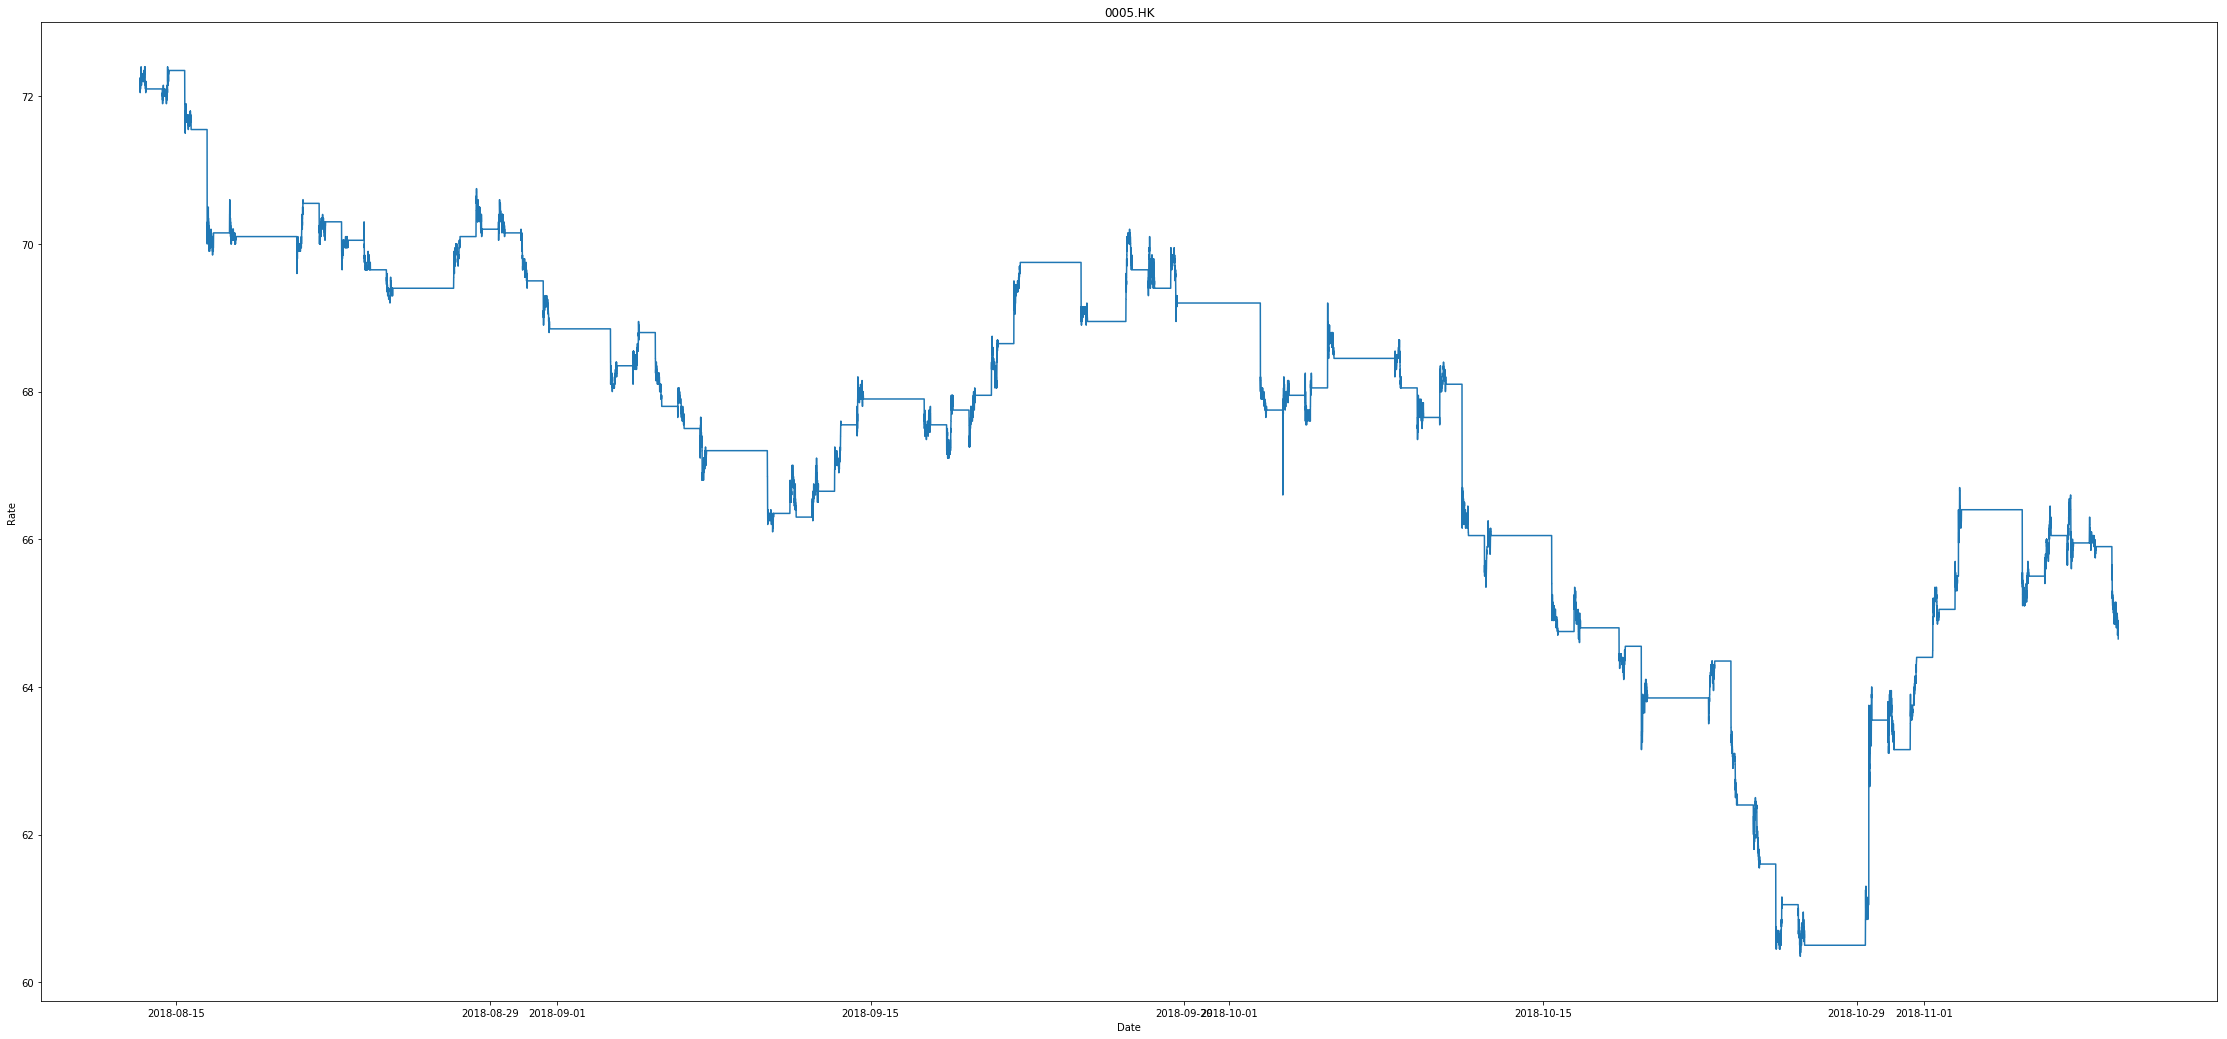

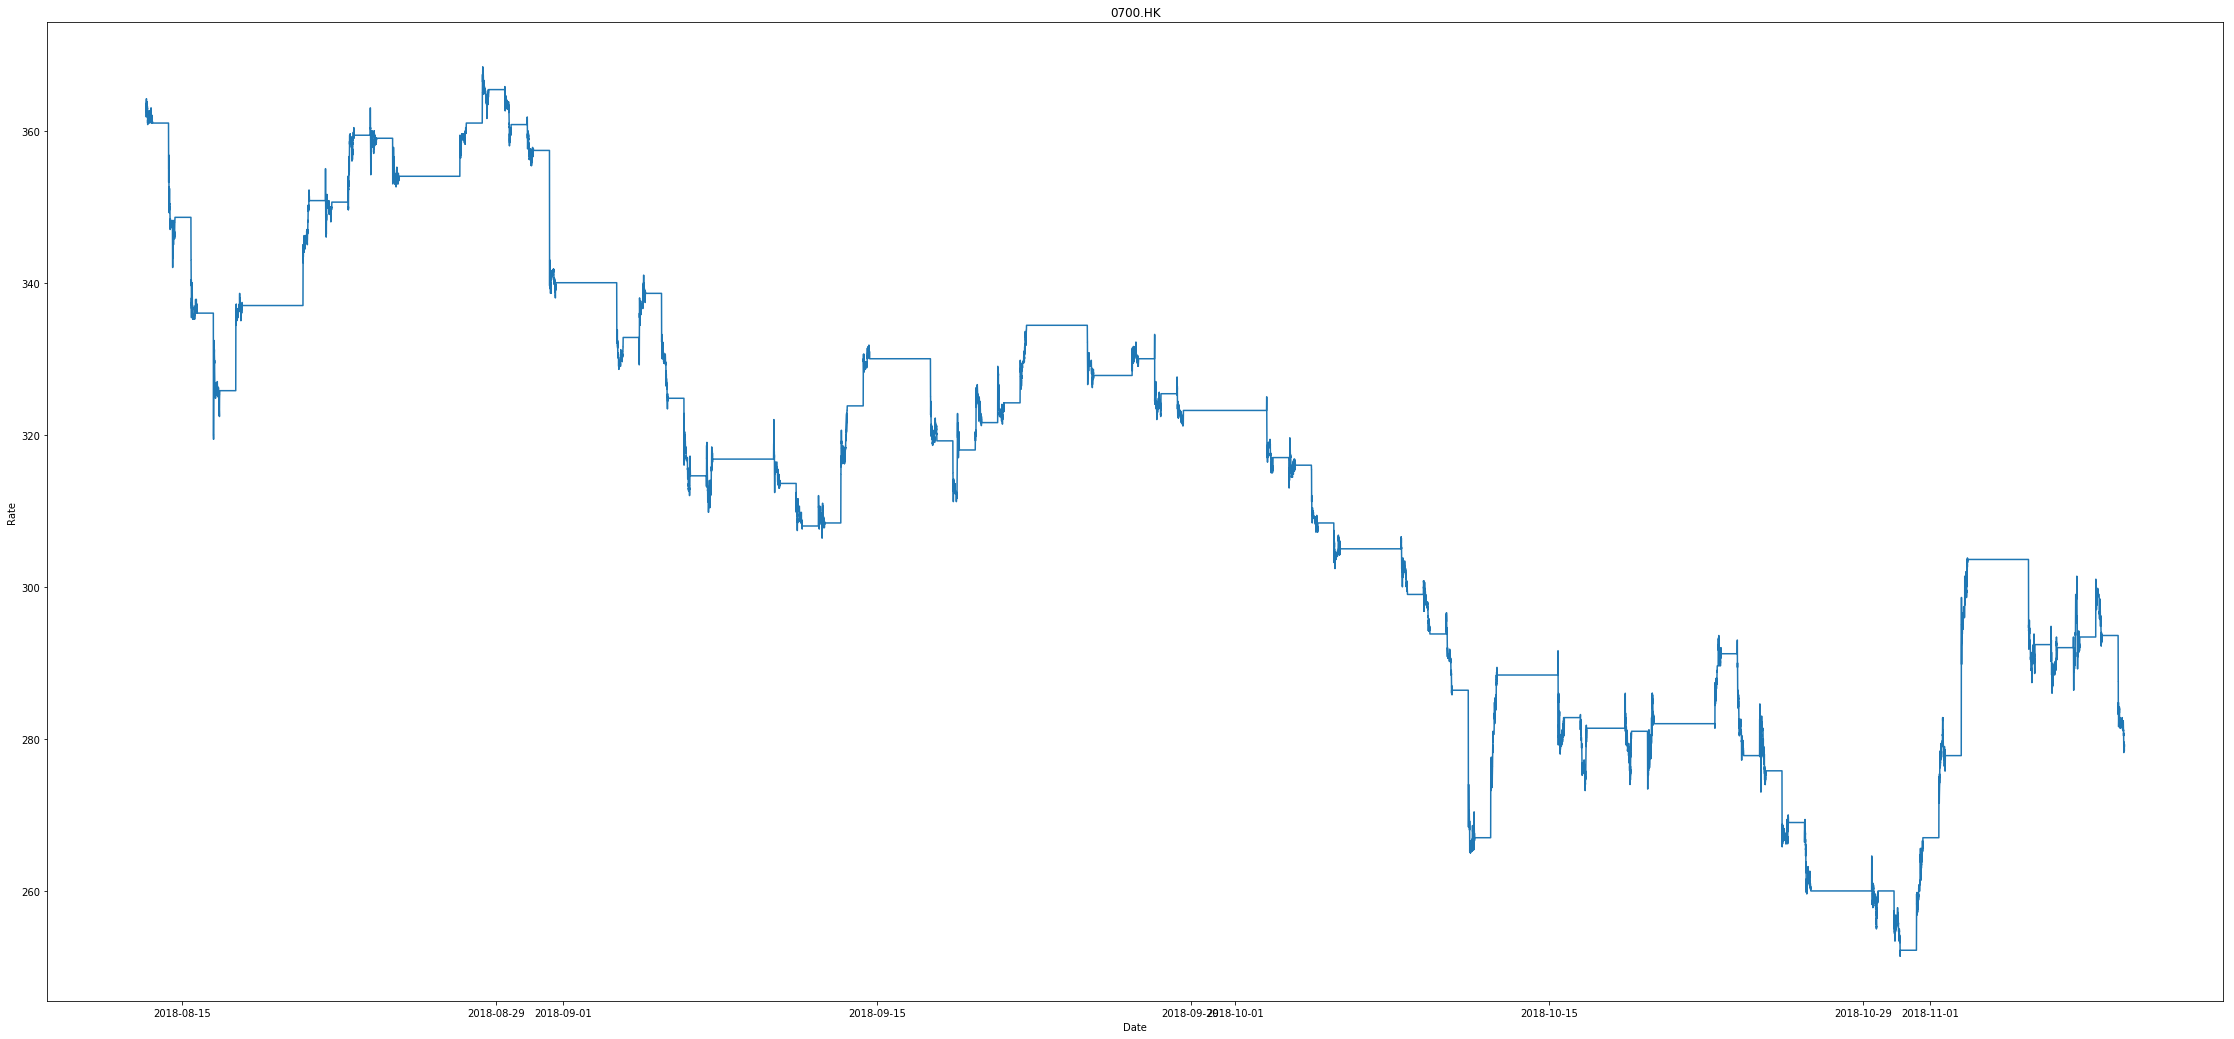

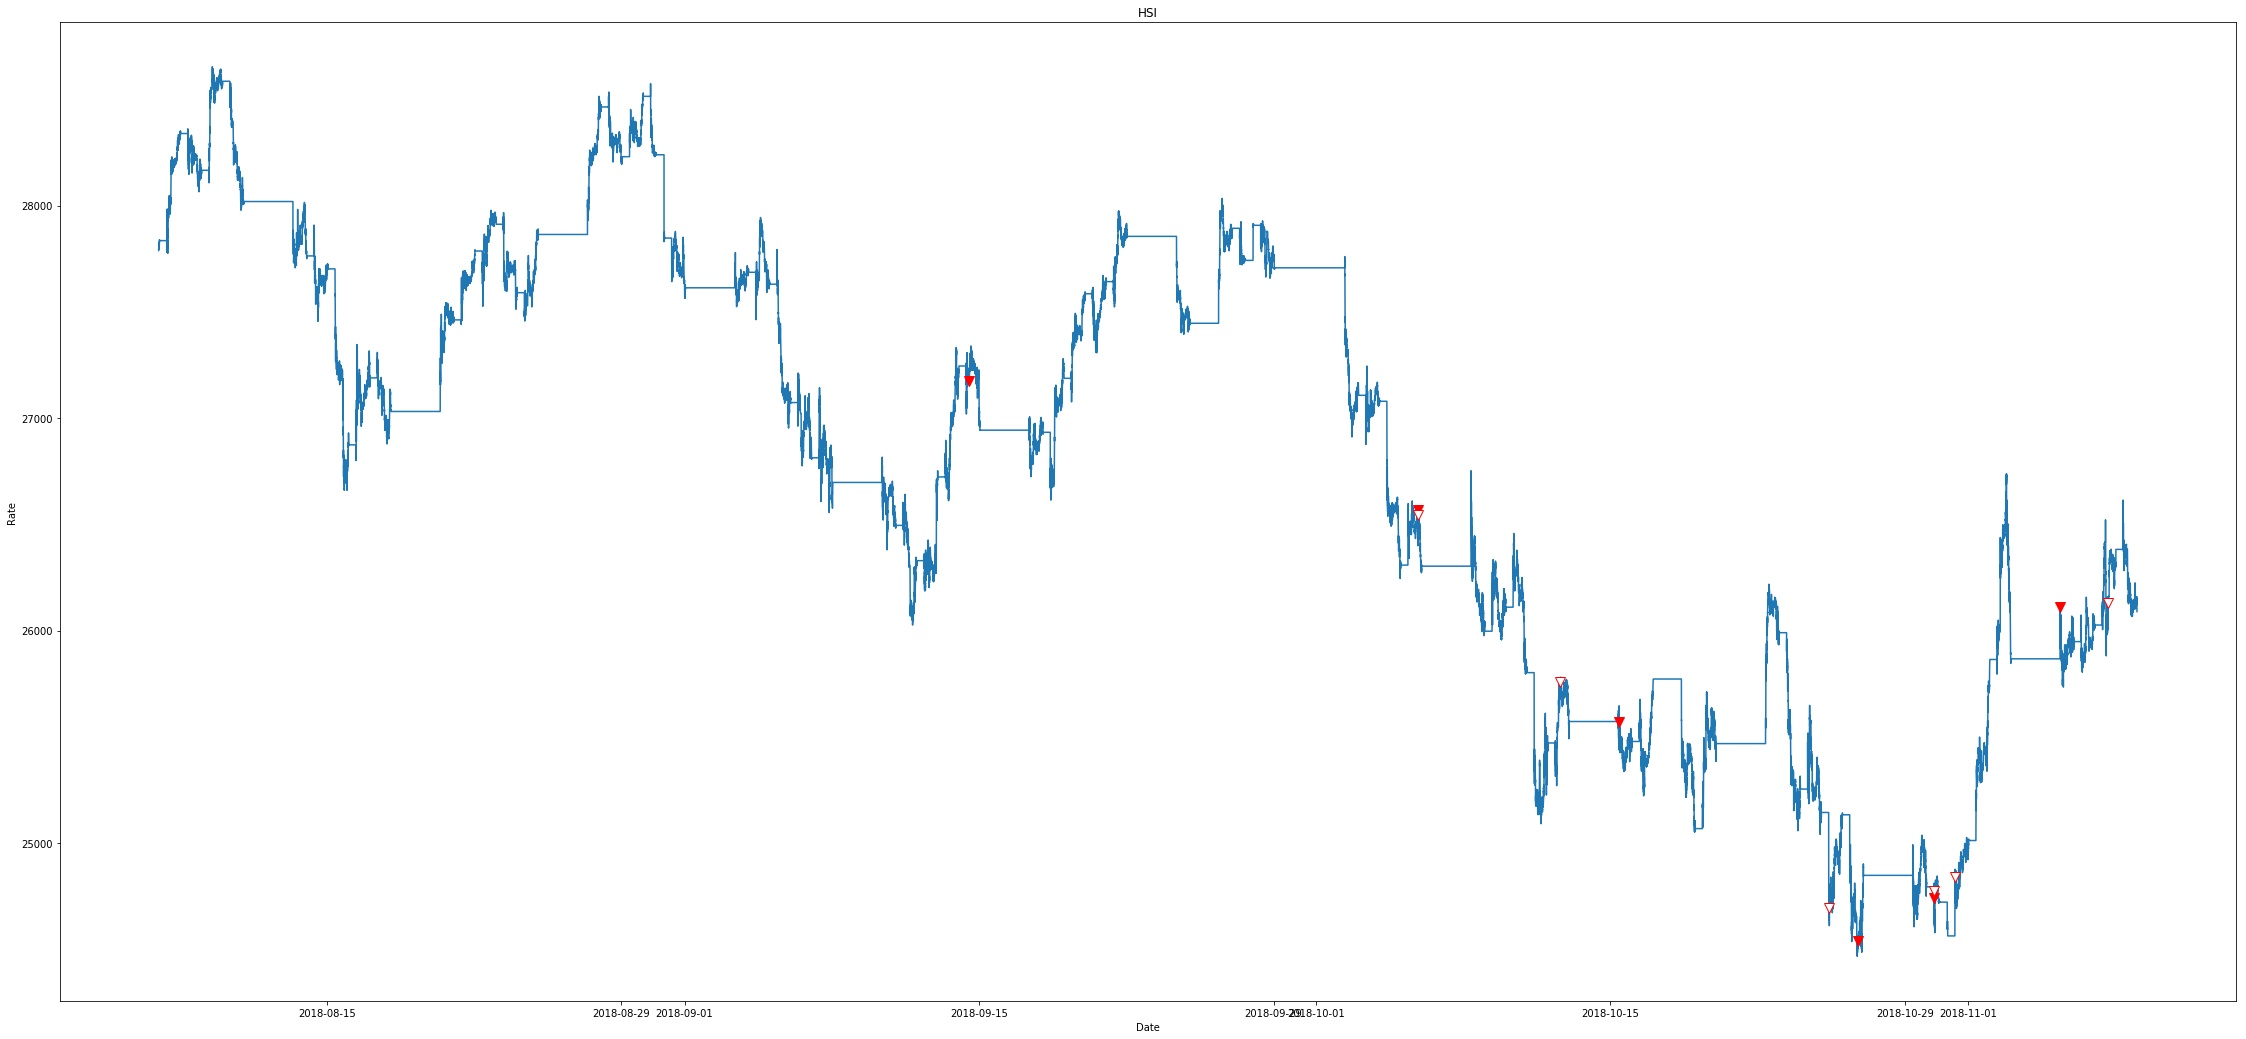

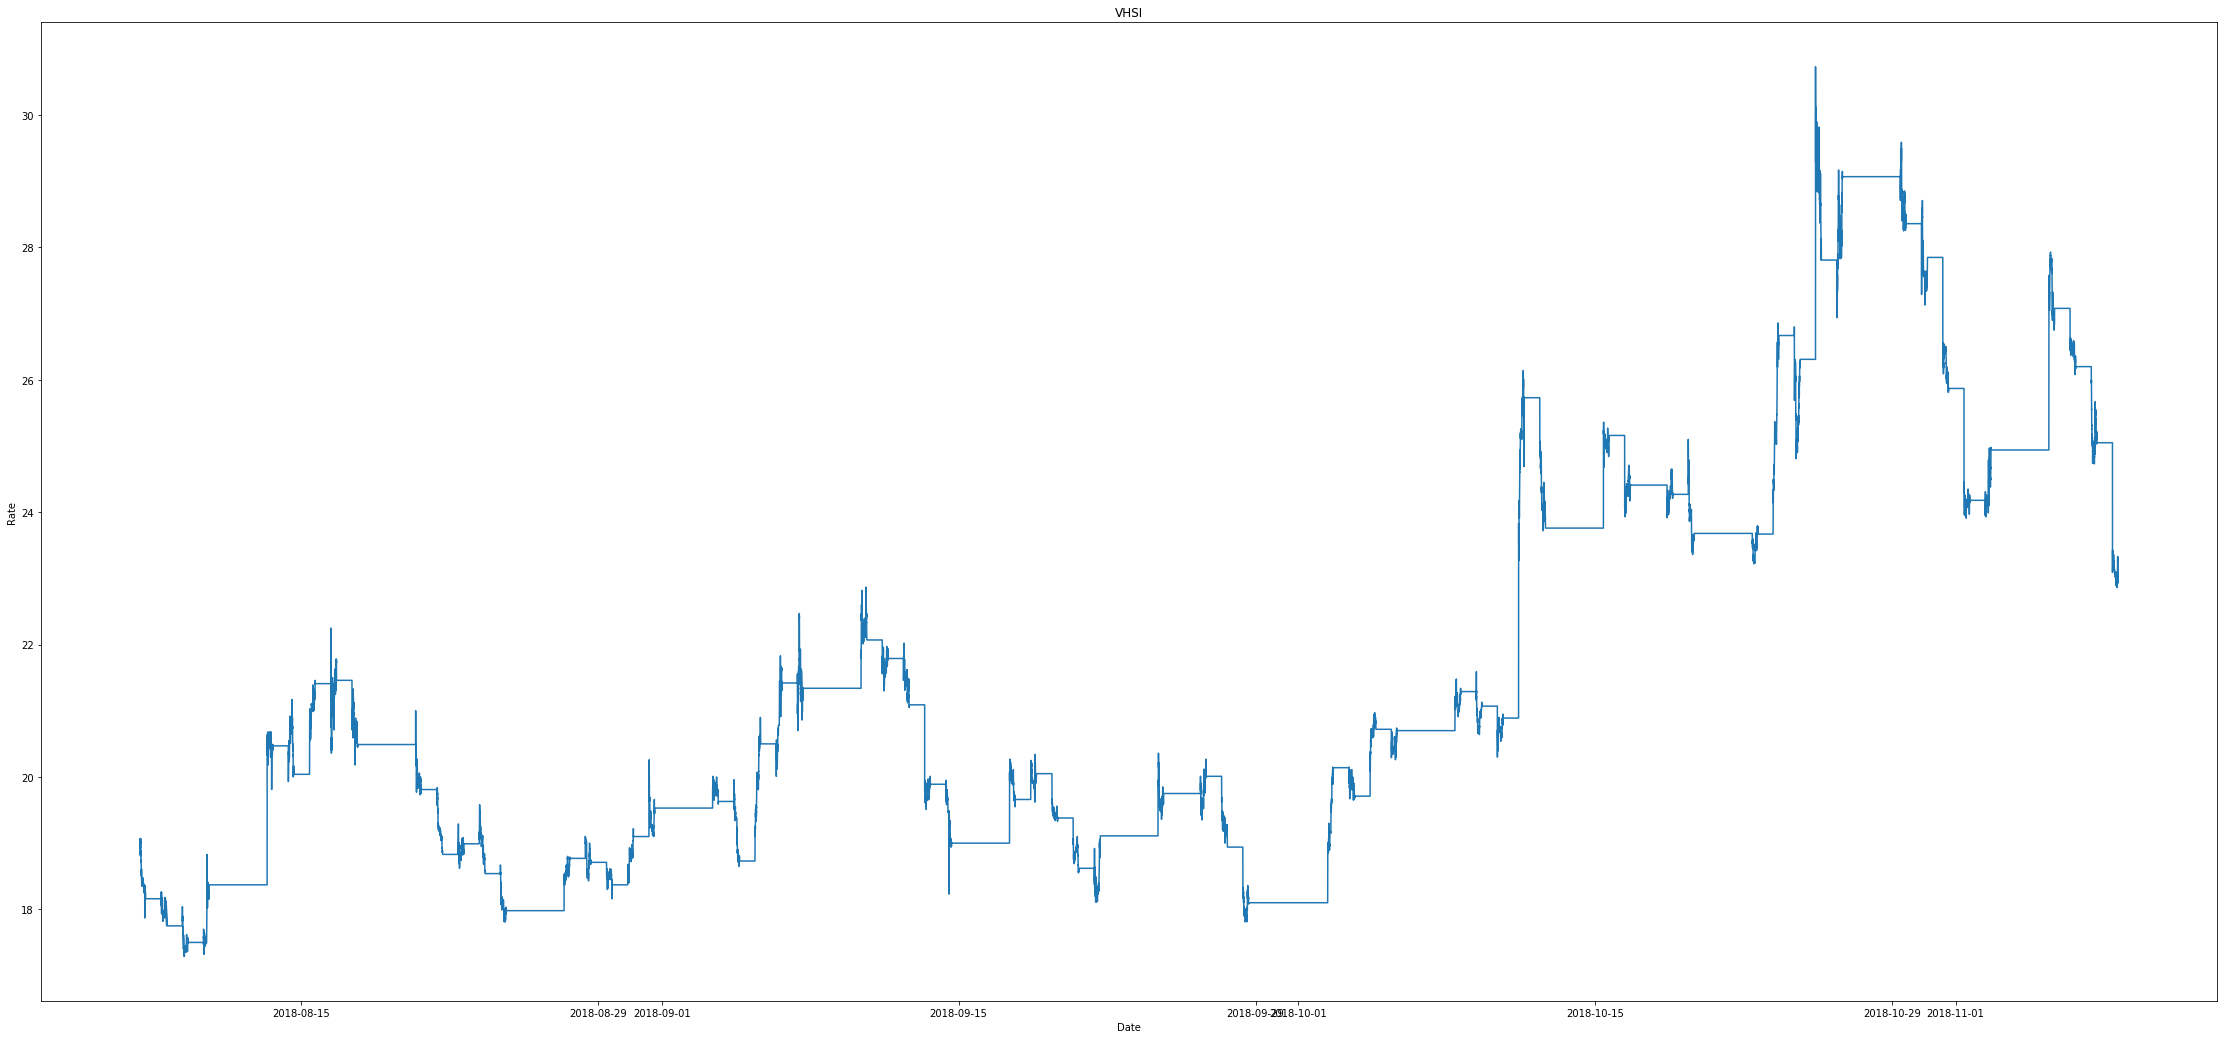

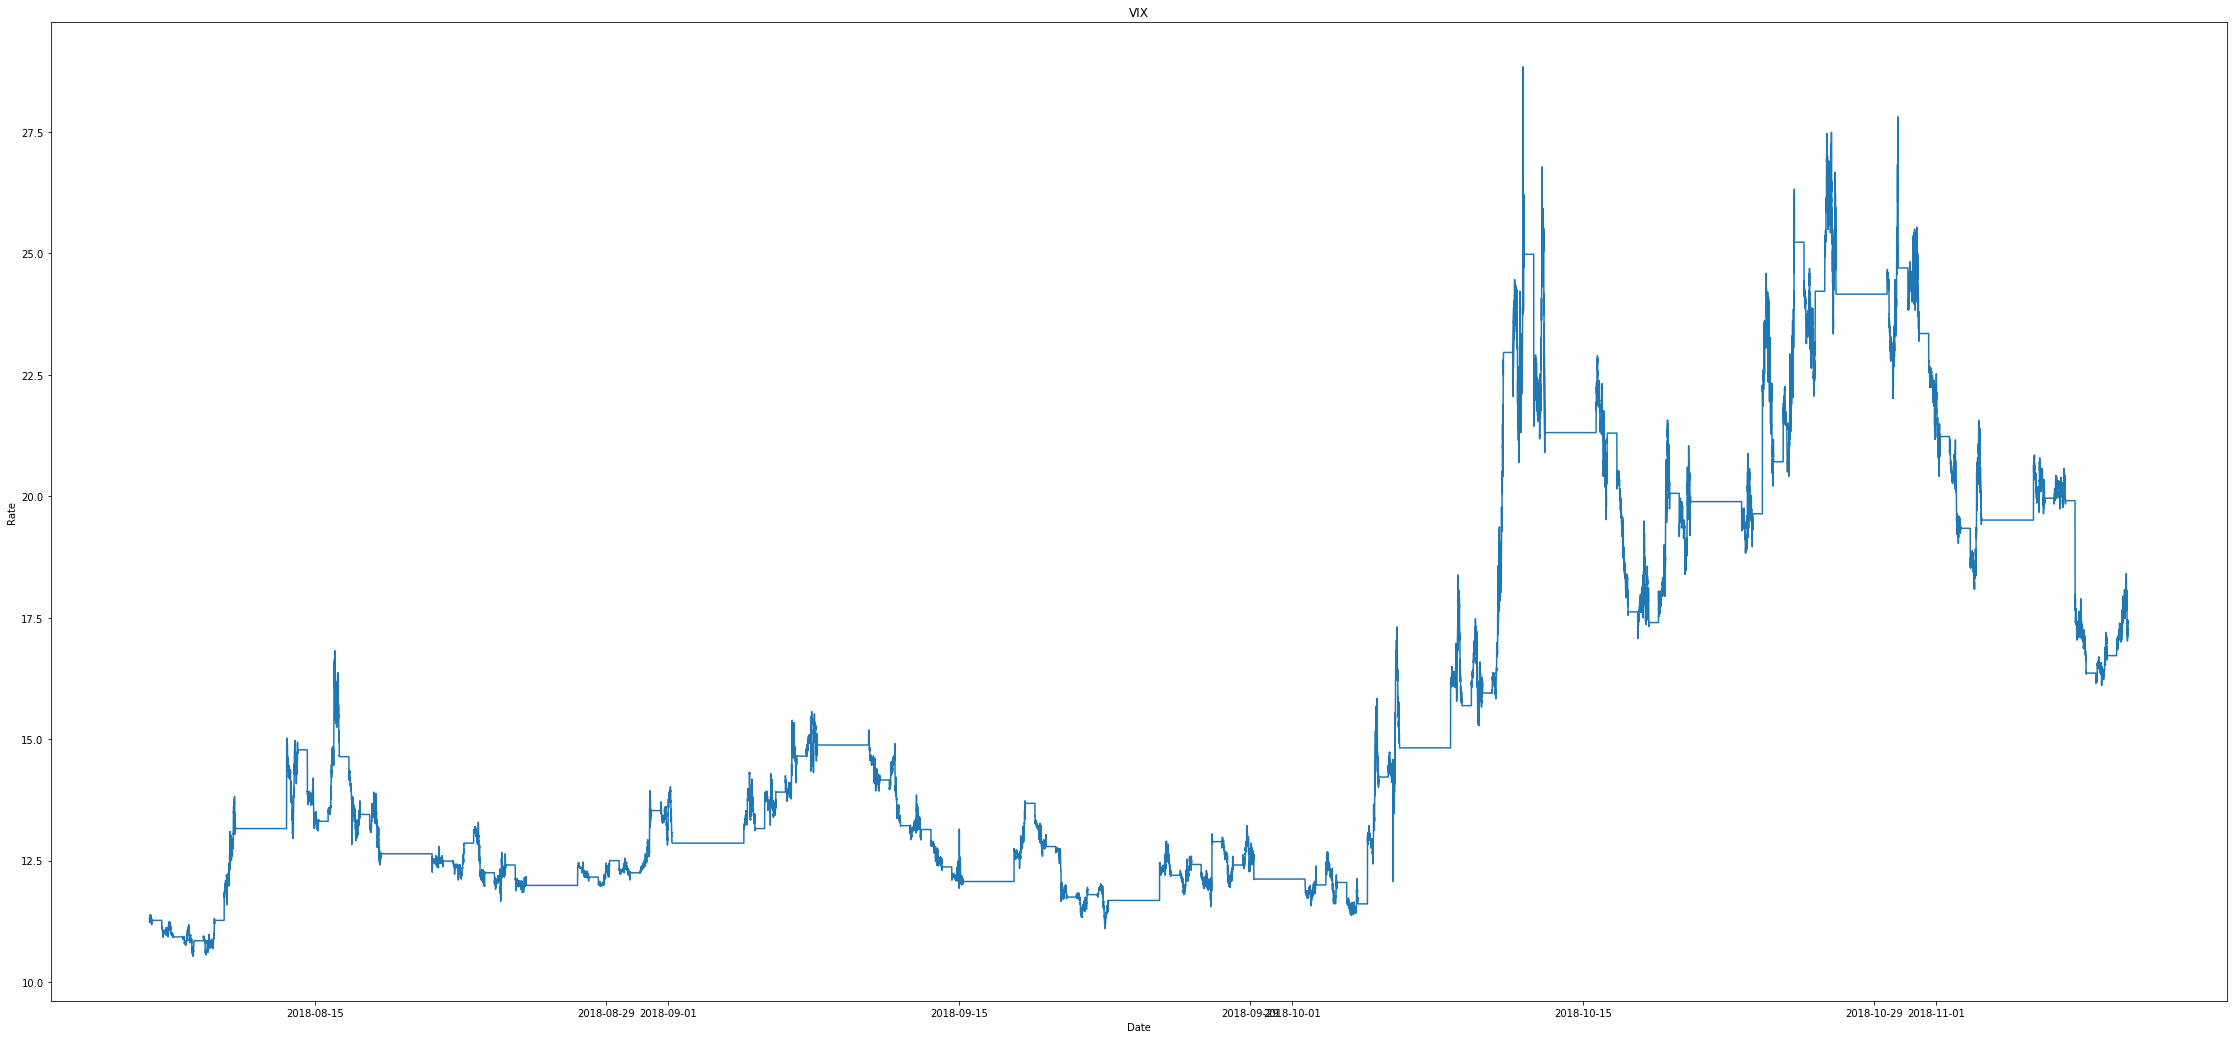

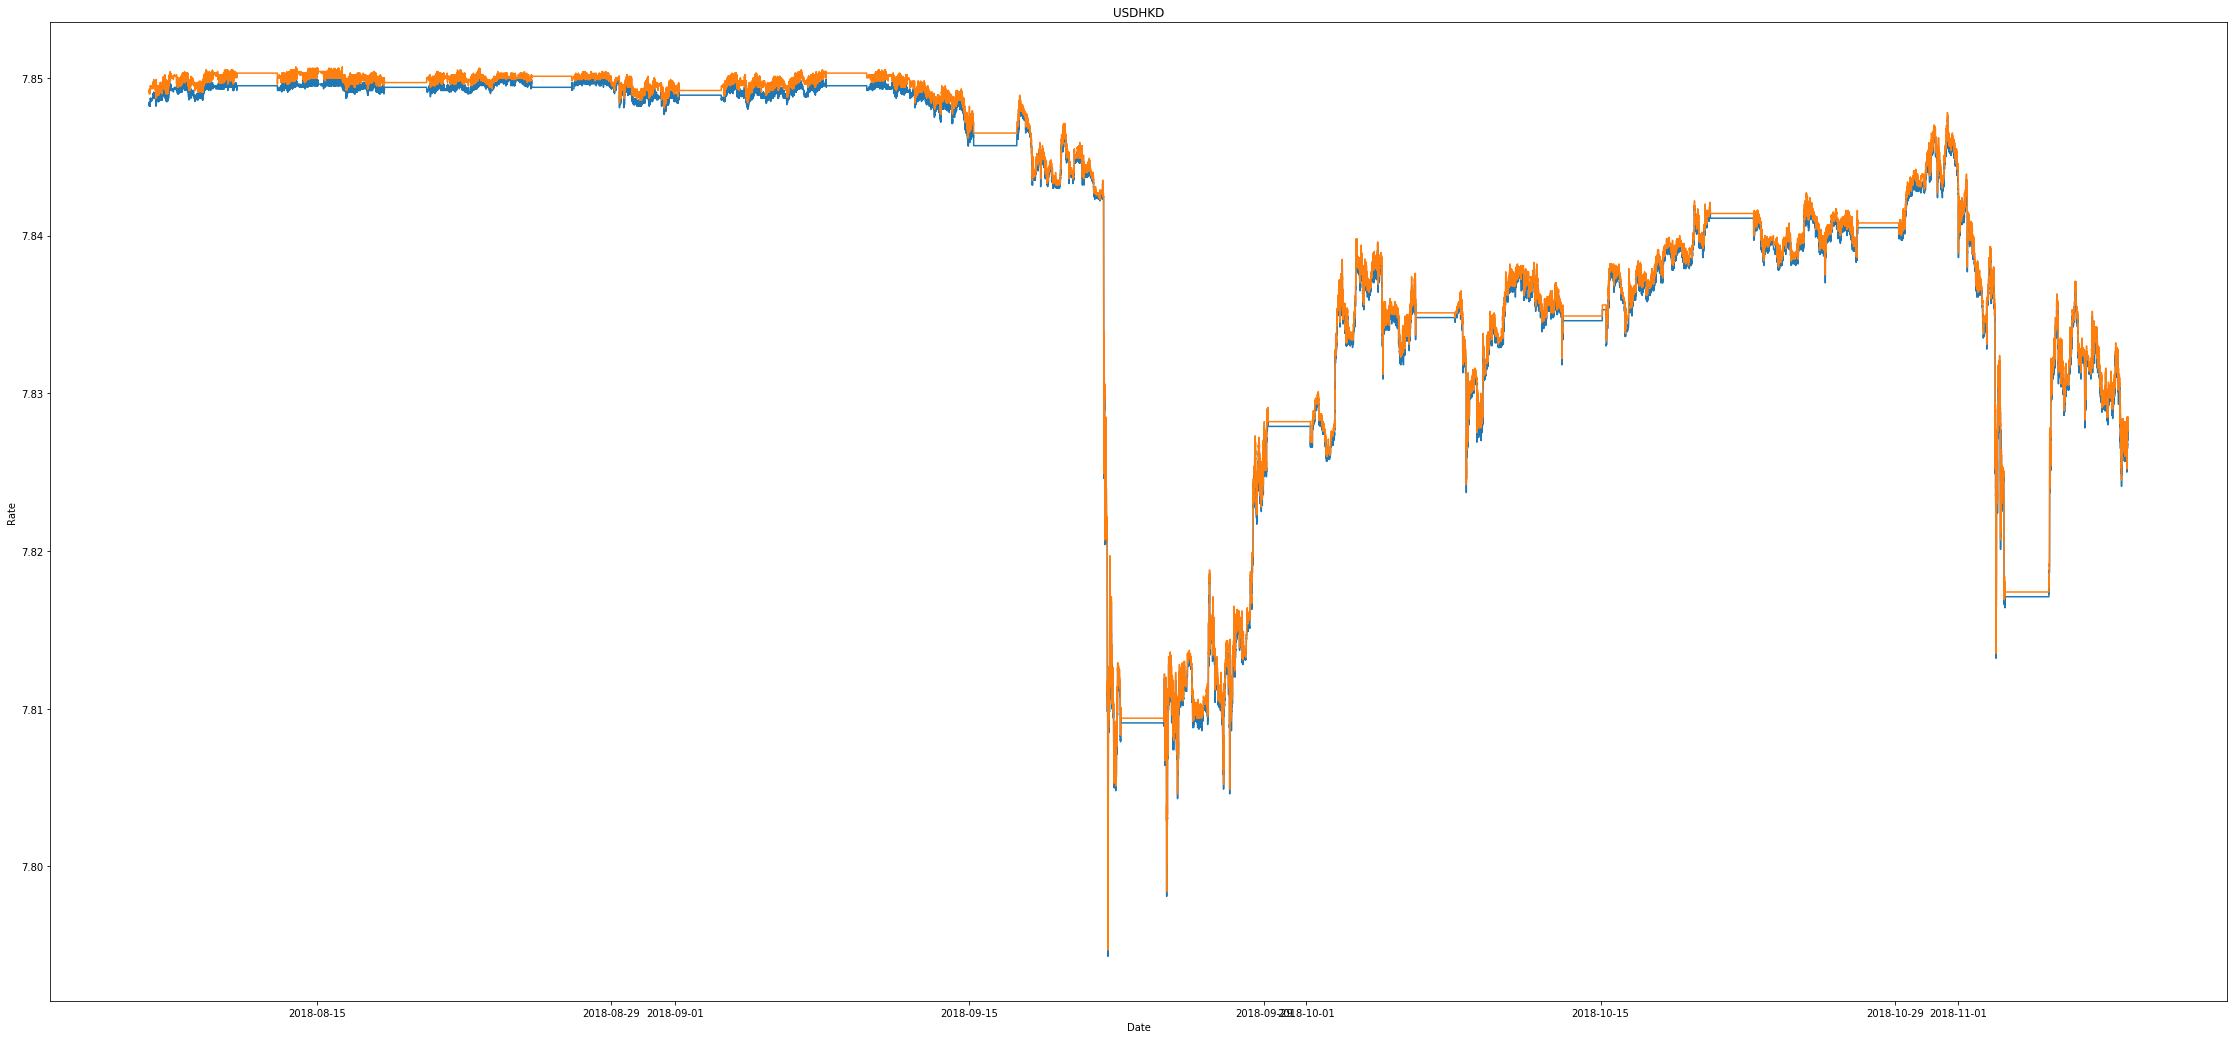

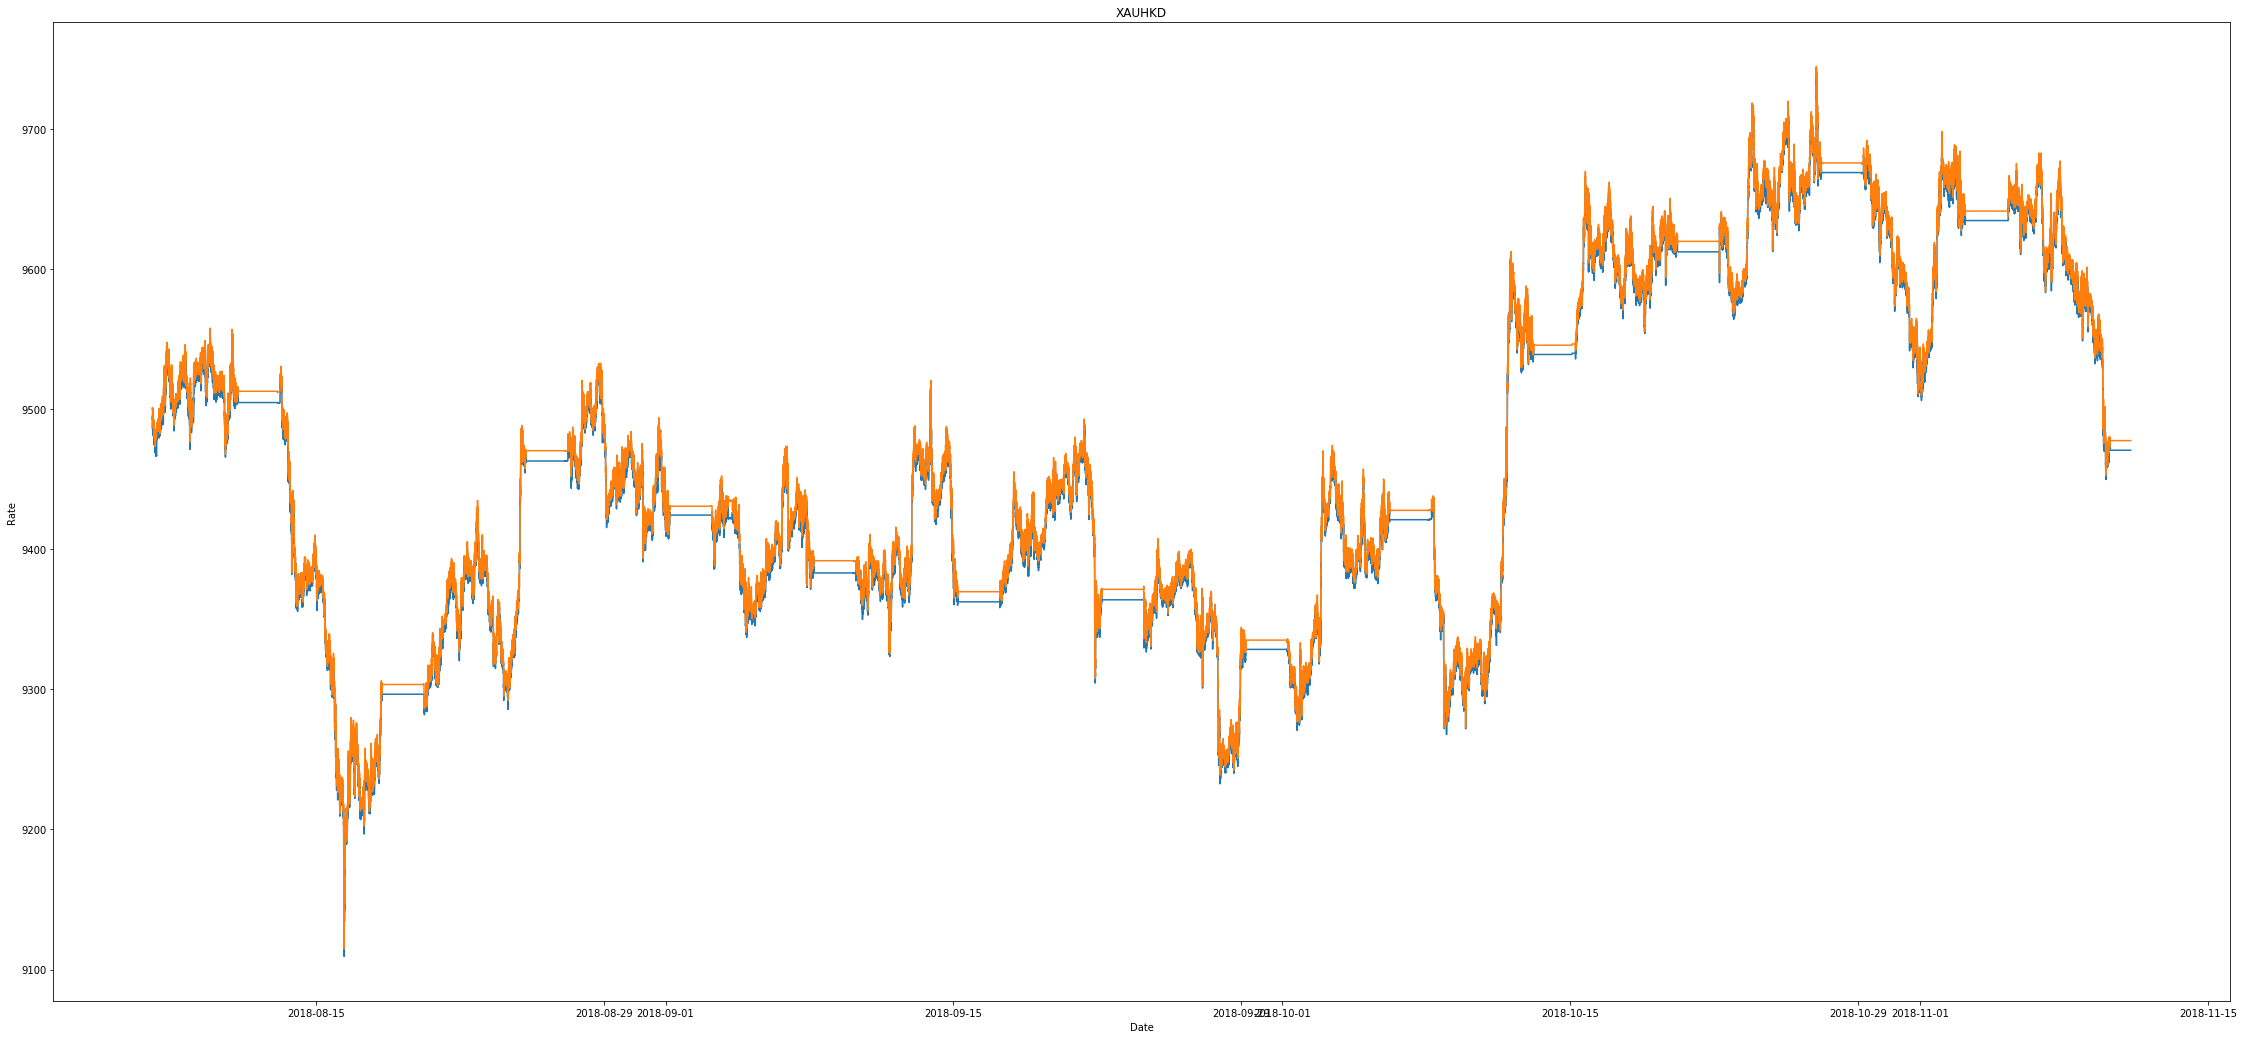

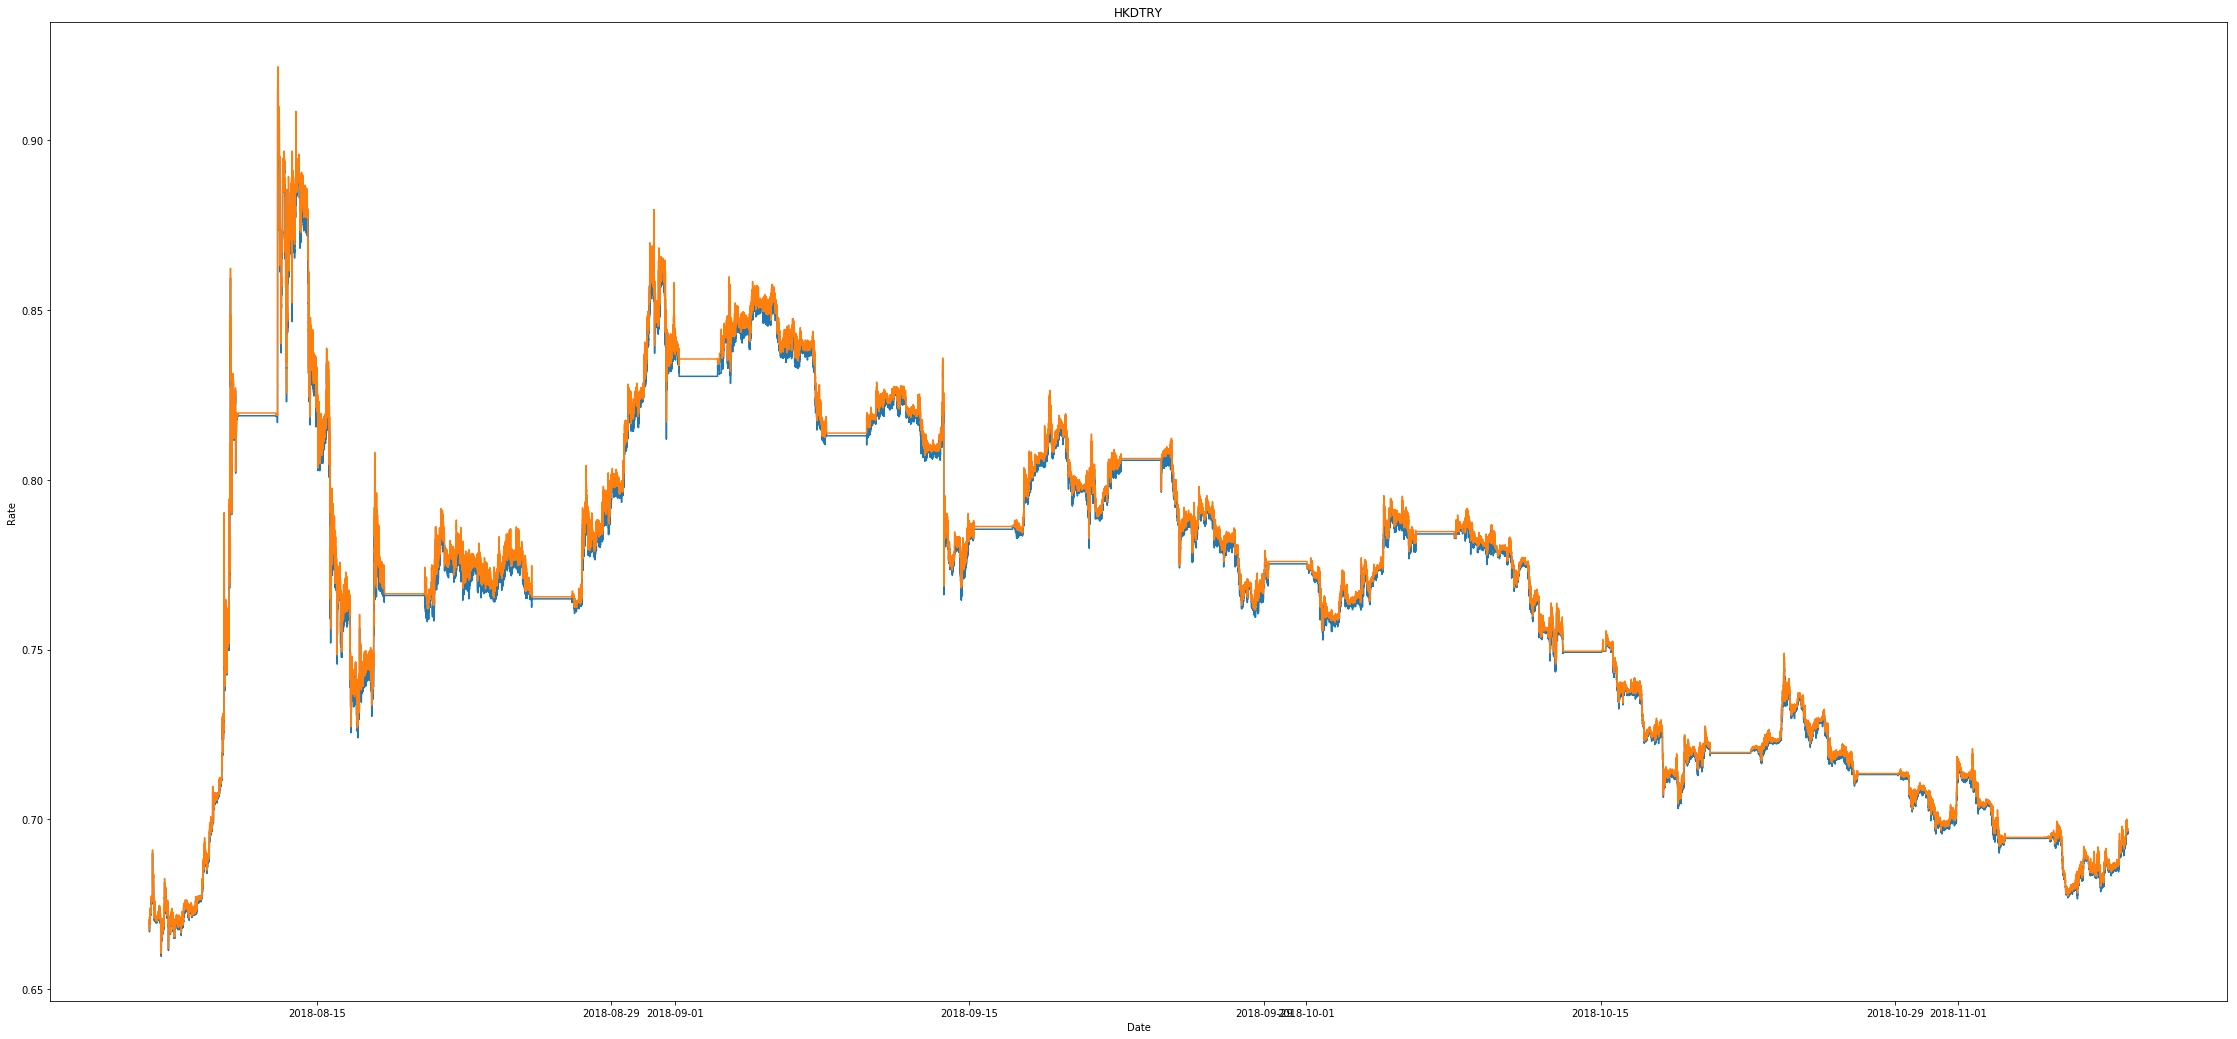

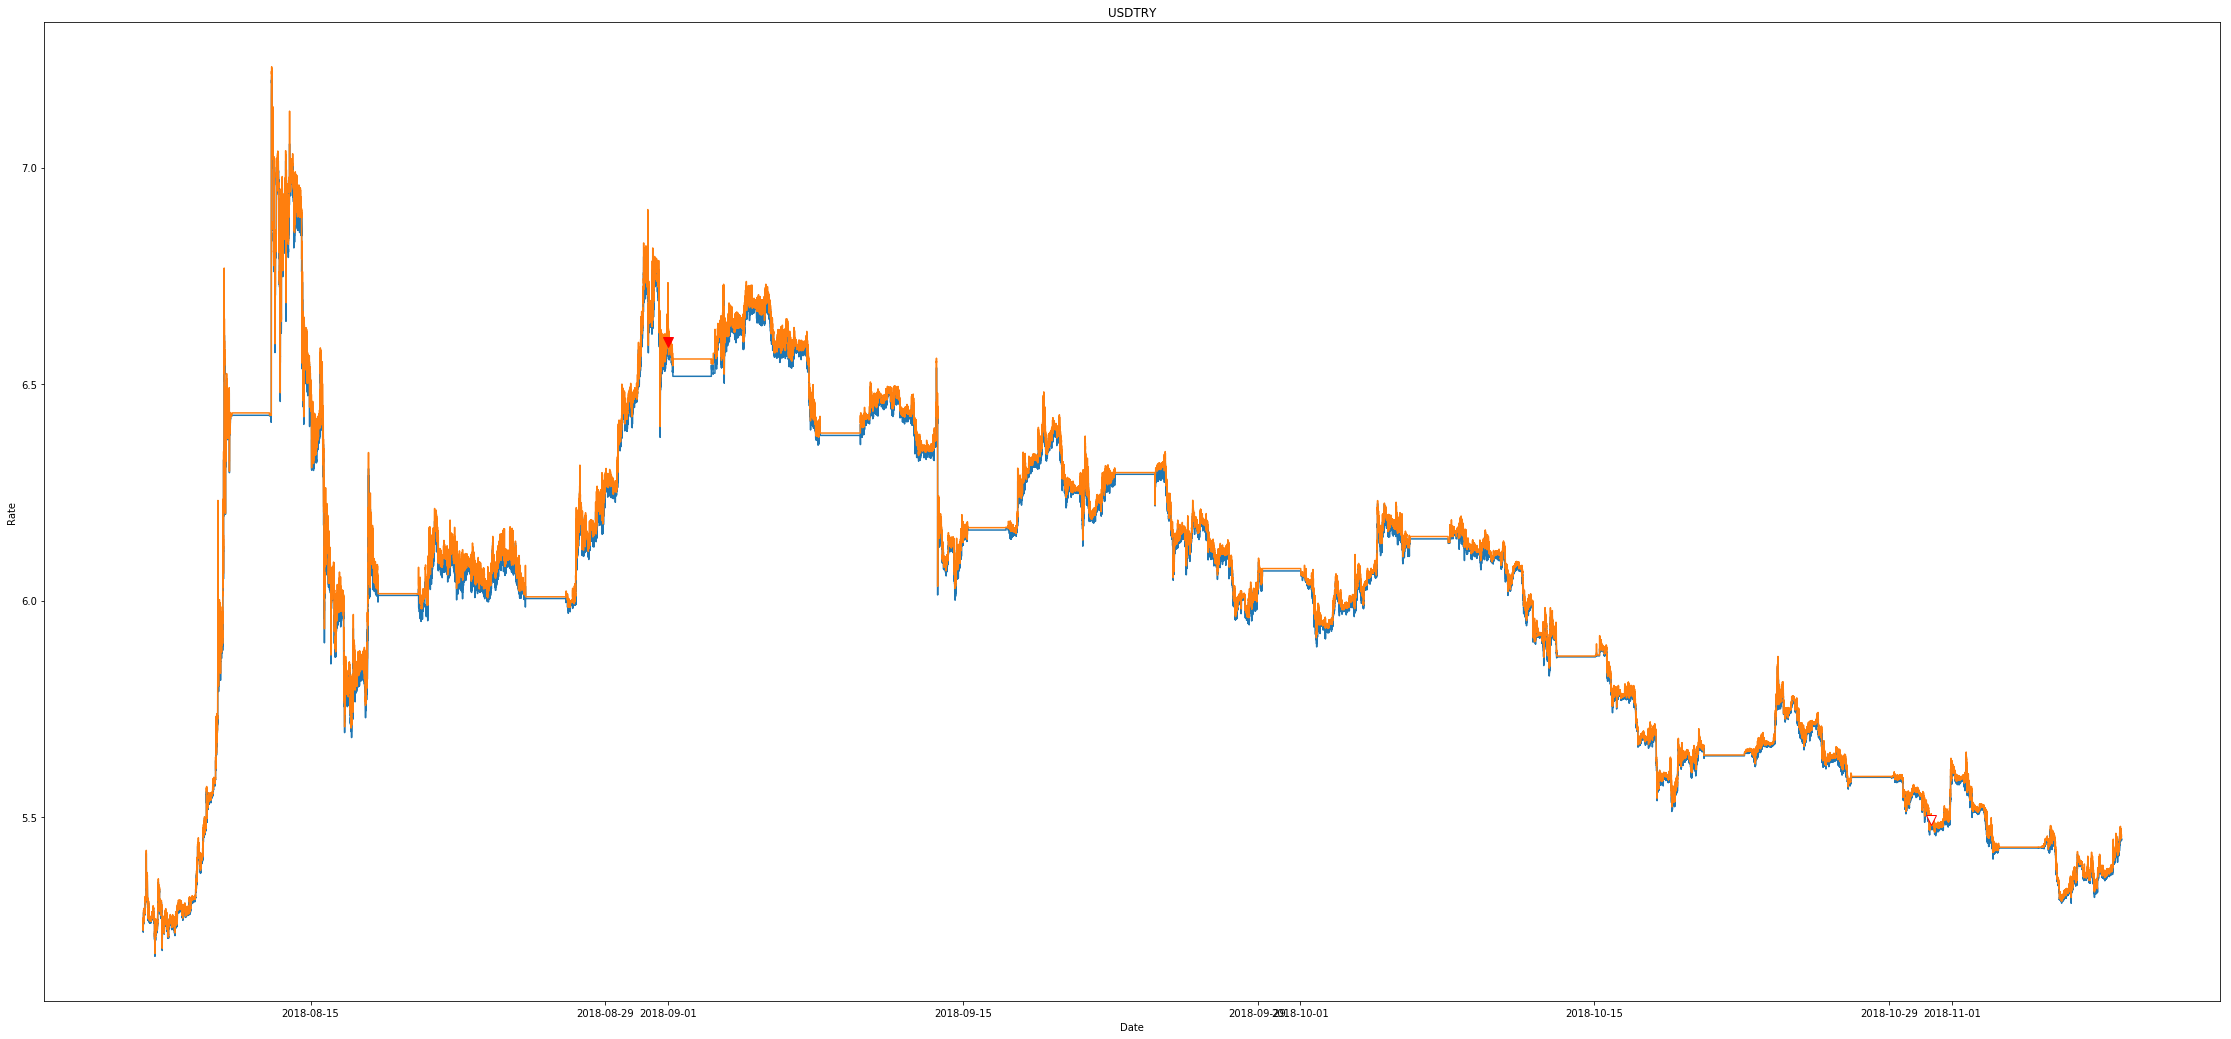

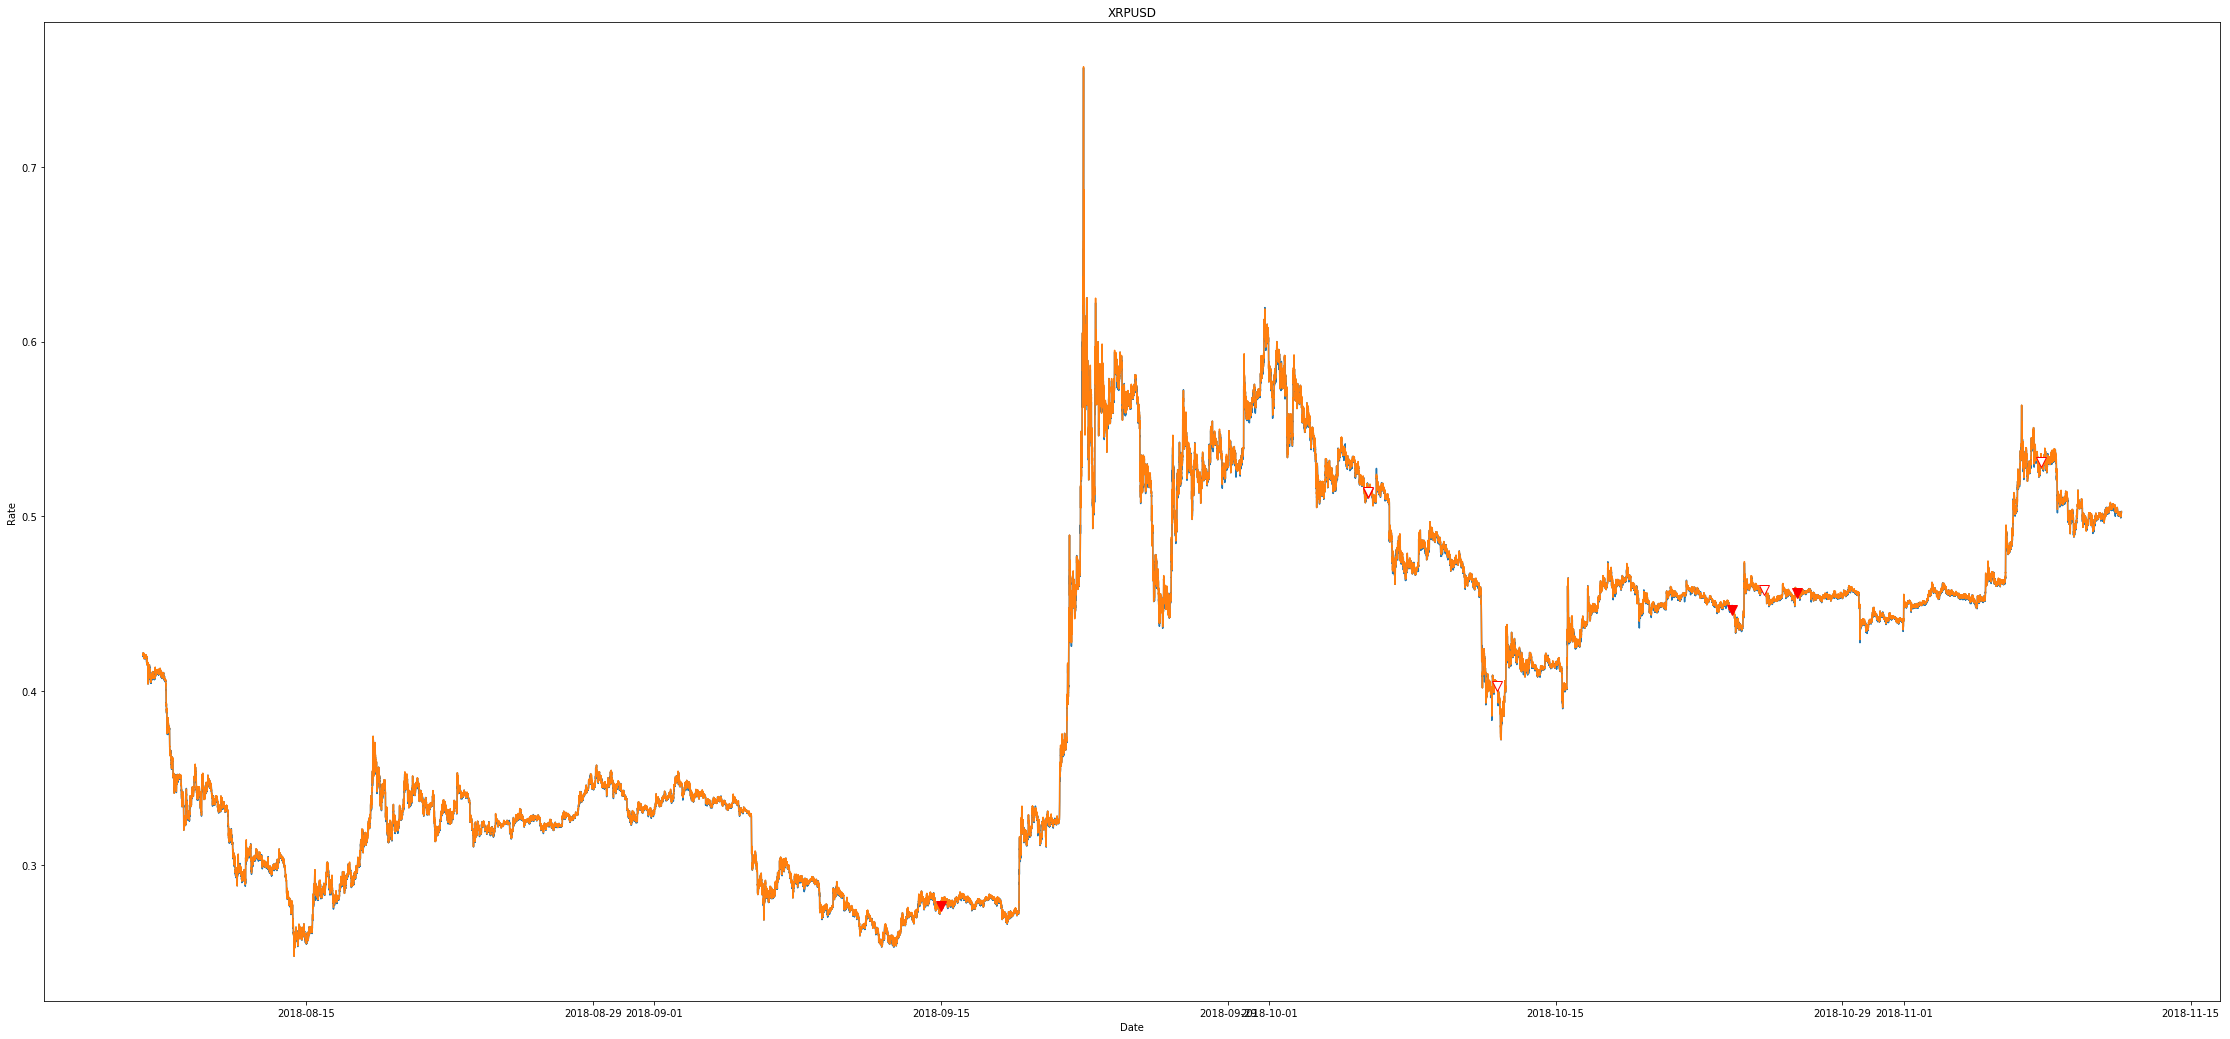

Activities:
   Product Position  Open Rate Close Rate        P&L
0   USDTRY    SHORT        6.6        5.5 35531647.4
1      HSI    SHORT    27175.0    26544.0    62900.0
2     CALL     LONG      767.8          0     7383.4
3   XRPUSD    SHORT        0.3        0.5     -385.6
4      HSI    SHORT    26568.0    25758.0    80800.0
5     CALL     LONG      874.1      359.4   -10493.8
6   XRPUSD    SHORT        0.5        0.4     -113.8
7      HSI    SHORT    25570.0    24695.0    87300.0
8     CALL     LONG      773.6      131.3   -13044.2
9   XRPUSD    SHORT        0.4        0.5     -209.0
10     HSI    SHORT    24539.0    24776.0   -23900.0
11    CALL     LONG      579.7      774.0     3687.1
12  XRPUSD    SHORT        0.5        0.5     -258.9
13     HSI    SHORT    24740.0    24841.0   -10300.0
14    CALL     LONG      543.4          0     -528.0
15     HSI    SHORT    26113.0    26130.0    -1900.0
16    CALL     LONG      844.0      828.5     -509.7
Summary:
Initial Cash: 10000000 Fi

In [12]:
from pylab import *
rcParams['figure.figsize'] = (39, 18)
#%% Export Portfolio 
portfolio, tradelog = platform.exporttrades()
temp_log = tradelog
for i in range(len(temp_log)): 
    temp_log.loc[i, 'P&L'] = temp_log.loc[i, 'Unrealized P&L'] + temp_log.loc[i, 'Realized P&L']
print ('Activities:')
print (tradelog[['Product', 'Position', 'Open Rate', 'Close Rate', 'P&L']])
print ('Summary:')
print ('Initial Cash:', round(portfolio['initial']), 'Final Cash:', round(portfolio['cash']))
print ('Unrealized P&L:', round(portfolio['Unrealized P&L']), 'Realized P&L:', round(portfolio['Realized P&L']))
print ('Overall P&L:', round(portfolio['P&L']), 'P&L%:', round(portfolio['P&L%']))